In [17]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)

import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
os.listdir('Downloads/archive.zip')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Downloads/archive.zip'

In [4]:
# Create a new directory
Data_Analytics = 'Data_Analytics'
os.mkdir(Data_Analytics)
base_dir = os.path.join(Data_Analytics, 'base_dir')
os.mkdir(base_dir)

#creating a path to'base_dir'

#train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

#val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

#creating seperate folders for each class

#inside Train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

#inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [15]:
df_data = pd.read_csv('Data Analytics/Data_Analytics/input/HAM10000_metadata.csv')
df_data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Data Analytics/Data_Analytics/input/HAM10000_metadata.csv'

In [25]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [27]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):

    unique_list = list(df['lesion_id'])

    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [28]:
df_data['duplicates'].value_counts()

duplicates
no_duplicates     5514
has_duplicates    4501
Name: count, dtype: int64

In [29]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [30]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [13]:
df_val['dx'].value_counts()

dx
nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: count, dtype: int64

In [31]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])

    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)

# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [15]:
df_val['dx'].value_counts()

dx
nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: count, dtype: int64

In [16]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [32]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('Downloads/input/HAM10000_images_part_1')
folder_2 = os.listdir('Downloads/input/HAM10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

train_dir = 'Data Analytics/base_dir/train_dir'

# Transfer the train images

for image in train_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('Downloads/input/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('Downloads/input/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

val_dir = 'Data Analytics/base_dir/val_dir'
# Transfer the val images

for image in val_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('Downloads/input/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('Downloads/input/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

KeyError: 'ISIC_0027419'

In [35]:
# check how many train images we have in each folder

print(len(os.listdir('Data Analytics/base_dir/train_dir/nv')))
print(len(os.listdir('Data Analytics/base_dir/train_dir/mel')))
print(len(os.listdir('Data Analytics/base_dir/train_dir/bkl')))
print(len(os.listdir('Data Analytics/base_dir/train_dir/bcc')))
print(len(os.listdir('Data Analytics/base_dir/train_dir/akiec')))
print(len(os.listdir('Data Analytics/base_dir/train_dir/vasc')))
print(len(os.listdir('Data Analytics/base_dir/train_dir/df')))

5954
6020
1024
484
303
131
109


In [37]:
# check how many val images we have in each folder

print(len(os.listdir('Data Analytics/base_dir/val_dir/nv')))
print(len(os.listdir('Data Analytics/base_dir/val_dir/mel')))
print(len(os.listdir('Data Analytics/base_dir/val_dir/bkl')))
print(len(os.listdir('Data Analytics/base_dir/val_dir/bcc')))
print(len(os.listdir('Data Analytics/base_dir/val_dir/akiec')))
print(len(os.listdir('Data Analytics/base_dir/val_dir/vasc')))
print(len(os.listdir('Data Analytics/base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [108]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']
from PIL import Image
for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    #os.mkdir(aug_dir)
    #create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    #os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('Data Analytics/base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'Data Analytics/base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    #shutil.rmtree('aug_dir')

Found 8069 images belonging to 1 classes.
Found 8069 images belonging to 1 classes.
Found 8069 images belonging to 1 classes.


PermissionError: [Errno 13] Permission denied: 'base_dir/train_dir/akiec\\.ipynb_checkpoints'

In [38]:
import tempfile
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

class_list = ['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
num_aug_images_wanted = 6000

def augment_class(class_name, base_dir, save_dir):
    with tempfile.TemporaryDirectory() as temp_dir:
        img_dir = os.path.join(temp_dir, 'img_dir')
        os.makedirs(img_dir)

        try:
            img_list = os.listdir(os.path.join(base_dir, class_name))
            for fname in img_list:
                src = os.path.join(base_dir, class_name, fname)
                dst = os.path.join(img_dir, fname)
                shutil.copyfile(src, dst)
        except FileNotFoundError as e:
            logger.error(f"Error copying files for class {class_name}: {e}")
            return

        datagen = ImageDataGenerator(
            rotation_range=180,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )
        aug_datagen = datagen.flow_from_directory(
            temp_dir,
            save_to_dir=save_dir,
            save_format='jpg',
            target_size=(224, 224),
            batch_size=50
        )

        num_files = len(os.listdir(img_dir))
        num_batches = int(np.ceil((num_aug_images_wanted - num_files) / 50))

        for _ in range(num_batches):
            next(aug_datagen)

for item in class_list:
    augment_class(item, 'Data Analytics/base_dir/train_dir', 'Data Analytics/base_dir/train_dir')

Found 6020 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.


PermissionError: [Errno 13] Permission denied: 'Data Analytics/base_dir/train_dir\\akiec\\.ipynb_checkpoints'

In [5]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('Data Analytics/base_dir/train_dir/nv')))
print(len(os.listdir('Data Analytics/base_dir/train_dir/mel')))
print(len(os.listdir('Data Analytics/base_dir/train_dir/bkl')))
print(len(os.listdir('Data Analytics/base_dir/train_dir/bcc')))
print(len(os.listdir('Data Analytics/base_dir/train_dir/akiec')))
print(len(os.listdir('Data Analytics/base_dir/train_dir/vasc')))
print(len(os.listdir('Data Analytics/base_dir/train_dir/df')))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Data Analytics/base_dir/train_dir/nv'

In [99]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc'))) 
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


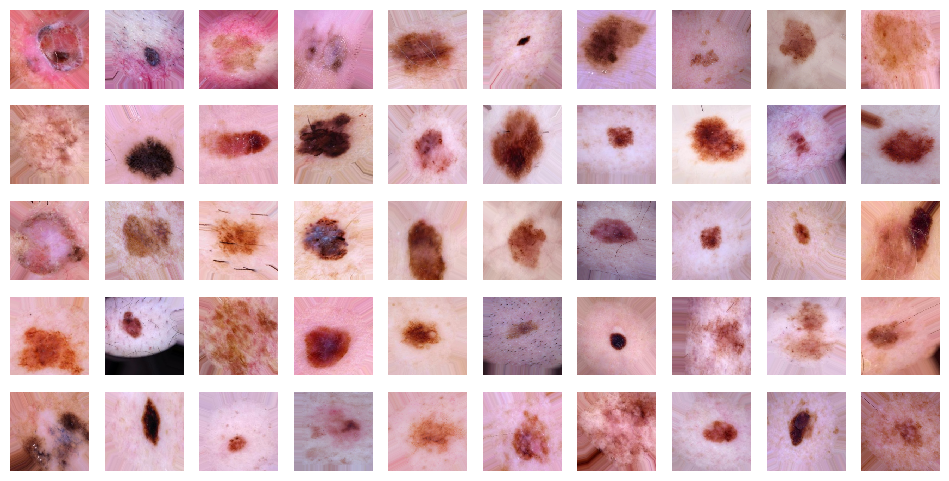

In [35]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

In [74]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = int(np.ceil(num_train_samples / train_batch_size))
val_steps = int(np.ceil(num_val_samples / val_batch_size))

In [37]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 14023 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [38]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [39]:
mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [40]:
type(mobile.layers)

list

In [41]:
# How many layers does MobileNet have?
len(mobile.layers)

91

In [87]:
# CREATE THE MODEL ARCHITECTURE
from tensorflow.keras.layers import Dropout, Dense, Flatten
# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

x = Flatten()(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [88]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,580,103 (13.66 MB)

 Trainable params: 2,214,919 (8.45 MB)

 Non-trainable params: 1,365,184 (5.21 MB)

In [89]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [90]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy


def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [91]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [92]:
print(model.output.shape)
print(model.target.shape)

(None, 7)


AttributeError: 'Functional' object has no attribute 'target'

In [93]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [94]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1, # akiec
    1: 1, # bcc
    2: 1, # bkl
    3: 1, # df
    4: 3, # mel # Try to make the model more sensitive to Melanoma.
    5: 1, # nv
    6: 1, # vasc
}

In [95]:
filepath = "model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1, 
                   callbacks=callbacks_list)

Epoch 1/30


C:\Users\marsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - categorical_accuracy: 0.6471 - loss: 23.9432 - top_2_accuracy: 0.8193 - top_3_accuracy: 0.9025
Epoch 1: val_top_3_accuracy improved from -inf to 0.84115, saving model to model.keras
908/908 ━━━━━━━━━━━━━━━━━━━━ 236s 253ms/step - categorical_accuracy: 0.6471 - loss: 23.9287 - top_2_accuracy: 0.8193 - top_3_accuracy: 0.9025 - val_categorical_accuracy: 0.2569 - val_loss: 4.1309 - val_top_2_accuracy: 0.7409 - val_top_3_accuracy: 0.8412 - learning_rate: 0.0100
Epoch 2/30
495/908 ━━━━━━━━━━━━━━━━━━━━ 1:32 224ms/step - categorical_accuracy: 0.7254 - loss: 2.8022 - top_2_accuracy: 0.8496 - top_3_accuracy: 0.9274

C:\Users\marsh\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


AttributeError: 'NoneType' object has no attribute 'items'